## Load dataset

In [116]:
import pandas as pd
import re
from PString import PString

In [117]:
df = pd.read_csv('pronunciations/pronunciation_sp.csv')
df.head()

,word,category,pronunciation
0,a,artigo,a
1,a,preposição,a
2,á-bê-cê,nome masculino,ˌa.bˌe.sˈe
3,a-pro·pó·si·to,nome masculino,a.pɾo.pˈɔ.zi.tʊ
4,à-von·ta·de,nome masculino,ˌa.võ.tˈa.dʒi


In [118]:
df.dropna(inplace=True, subset=['word', 'pronunciation'])
df.drop_duplicates(inplace=True, subset=['word'])
df.shape

(53397, 3)

In [119]:
df['pronunciation'] = df['pronunciation'].apply(lambda v: v.split('$')[0].strip() if '$' in v else v.strip())

In [120]:
print(df.loc[18754])
df.at[18754, 'pronunciation'] = 'dʒis.ko.lˈa.ʒẽj' # fix pronunciation

print(df.loc[44141])
df.at[44141, 'pronunciation'] = 'pˌə.nʊ.krˈu' # fix pronunciation

word                     des·co·la·gem
category                 nome feminino
pronunciation    dʒis.ko.lˈa.ʒẽjʌ̃j_m
Name: 18754, dtype: object
word                  pa·no-cru
category         nome masculino
pronunciation       pˌə.nʊ.crˈu
Name: 44141, dtype: object


In [121]:
df['pronunciation_clean'] = df['pronunciation'].apply(lambda v: PString(re.sub('[ ˌ.ˈ_\-]', '', v)))
df['word_clean'] = df['word'].apply(lambda v: re.sub('[ˌ·ˈ\'_]', '', v).replace(' ', '-').lower())
df.head()

,word,category,pronunciation,pronunciation_clean,word_clean
0,a,artigo,a,a,a
2,á-bê-cê,nome masculino,ˌa.bˌe.sˈe,abese,á-bê-cê
3,a-pro·pó·si·to,nome masculino,a.pɾo.pˈɔ.zi.tʊ,apɾopɔzitʊ,a-propósito
4,à-von·ta·de,nome masculino,ˌa.võ.tˈa.dʒi,avõtadʒi,à-vontade
5,a·a,nome feminino,a.ˈa,aa,aa


In [122]:
def get_chars_list(series):
    return series.apply(list).apply(pd.Series).stack().unique()

In [123]:
tokens = get_chars_list(df['pronunciation_clean'])
print(f'Tokens: {tokens}')
print(f'Number of tokens: {len(tokens)}')

chars = get_chars_list(df['word_clean'])
print(f'Chars: {chars}')
print(f'Number of chars: {len(chars)}')

Tokens: ['a' 'b' 'e' 's' 'p' 'ɾ' 'o' 'ɔ' 'z' 'i' 't' 'ʊ' 'v' 'õ' 'dʒ' 'w' 'x'
 'tʃ' 'g' 'd' 'j' 'ə' 'k' 'ə̃' 'ʃ' 'ʒ' 'f' 'm' 'ẽ' 'n' 'u' 'l' 'r' 'ʎ'
 'ɛ' 'ɛ̃' 'ɲ' 'ũ' 'ĩ' 'ɨ' 'ɐ̃' 'h' 'ŋ' 'ɫ' 'ɔ̃']
Number of tokens: 45
Chars: ['a' 'á' '-' 'b' 'ê' 'c' 'p' 'r' 'o' 'ó' 's' 'i' 't' 'à' 'v' 'n' 'd' 'e'
 'l' 'g' 'x' 'j' 'f' 'm' 'u' 'ç' 'ã' 'z' 'h' 'q' 'ô' 'é' 'í' 'ú' 'â' 'y'
 'õ' 'w' 'k' 'ï']
Number of chars: 40


In [36]:
df[['word_clean','pronunciation_clean']].to_csv('pronunciations/pronunciation_sp_clean.csv', index=False)
df['word_clean'].to_csv('pronunciations/pronunciation_sp_clean.txt', index=False, header=False)

In [124]:
df_val = df.sample(frac=0.1, random_state=82)
df_val.shape

(5340, 5)

In [11]:
df_val['word_clean'].to_csv('pronunciations/pronunciation_sp_val.txt', index=False, header=False)

## G2P

### Epitran G2P

In [125]:
from pandarallel import pandarallel
import epitran

pandarallel.initialize(progress_bar=False)

def epitran_g2p(text, epi):
    """
    Roda e pré-processa g2p do epitran para uma frase
    """
    return epi.transliterate(u'{}'.format(text))

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [126]:
epi = epitran.Epitran('por-Latn')

In [127]:
df_val['epitran_pronunciation'] = df_val.parallel_apply(lambda row: epitran_g2p(row['word_clean'], epi), axis=1) # too slow
df_val['epitran_pronunciation'].head()

32572        impoɾtuno
62413           viɾɐdo
32298    imɛdiɐtɐmɛntɛ
38187          mɐleolo
26042     ɛʃtɾɛptokoko
Name: epitran_pronunciation, dtype: object

In [128]:
df_val['epitran_pronunciation_clean'] = df_val['epitran_pronunciation'].apply(lambda v: v.replace('-', ''))
df_val['epitran_pronunciation_clean'].head()

32572        impoɾtuno
62413           viɾɐdo
32298    imɛdiɐtɐmɛntɛ
38187          mɐleolo
26042     ɛʃtɾɛptokoko
Name: epitran_pronunciation_clean, dtype: object

### Read G2P transcripts

In [129]:
import subprocess
from phonecodes.src.phonecodes import xsampa2ipa

def translate_xsampa(text):
    """
    Transforma XSAMPA para IPA (saída do falabrasil é em XSAMPA)
    """
    return ' '.join('_'.join(xsampa2ipa(char, 'por-BR') for char in word.split('_')) for word in text.split())

In [130]:
def clean_espeak_transcript(transcript):
    transcript = transcript.strip().replace('ɾ_ə', 'ɾ')
    return re.sub('__(a_ɡ_u_d_ʊ|s_i_r_k_ũ_ŋ_f_l_ɛ_k_s_ʊ|ɡ_r_a_v_i|tʃ_iʊ)_', '', transcript).replace('_', '')

def remove_whitespaces(transcript):
    return translate_xsampa(transcript).replace(' ', '')

In [131]:
df_espeak = pd.read_csv('pronunciations/pronunciation_sp_val_espeak.csv', header=None)
df_espeak.columns = ['word_clean', 'espeak_pronunciation']
df_espeak.head()

,word_clean,espeak_pronunciation
0,importuno,i_m_p_o_ɾ_ə_t_u_n_ʊ
1,virado,v_i_ɾ_a_d_ʊ
2,imediatamente,i_m_e_dʒ_i__a_t_æ_m_eɪ_ŋ_tʃ_y
3,maléolo,m_a_l_ɛ_ɔ_l_ʊ
4,estreptococo,e_s_t_r_e_p_t_o_k_ɔ_k_ʊ


In [132]:
df_espeak['espeak_pronunciation_clean'] = df_espeak['espeak_pronunciation'].apply(clean_espeak_transcript)
df_espeak['espeak_pronunciation_clean'].head()

0           impoɾtunʊ
1              viɾadʊ
2    imedʒiatæmeɪŋtʃy
3             malɛɔlʊ
4        estreptokɔkʊ
Name: espeak_pronunciation_clean, dtype: object

In [133]:
df_falabrasil = pd.read_csv('pronunciations/pronunciation_sp_val_falabrasil.csv', header=None)
df_falabrasil.columns = ['word_clean', 'falabrasil_pronunciation']
df_falabrasil.head()

,word_clean,falabrasil_pronunciation
0,importuno,i~ p o X t u~ n u
1,virado,v i r a d u
2,imediatamente,i~ m e dZ i a t a m e~ tS i
3,maléolo,m a l E o l u
4,estreptococo,e s t r e p t o k o k u


In [134]:
df_falabrasil['falabrasil_pronunciation_clean'] = df_falabrasil['falabrasil_pronunciation'].apply(remove_whitespaces)
df_falabrasil['falabrasil_pronunciation_clean'].head()

0          ĩpoχtũnu
1              viradu
2    ĩmedʒiatamẽtʃi
3             malɛolu
4        estreptokoku
Name: falabrasil_pronunciation_clean, dtype: object

In [135]:
df_phonetisaurus = pd.read_csv('pronunciations/pronunciation_sp_val_phonetisaurus.csv', header=None)
df_phonetisaurus.columns = ['word_clean', 'phonetisaurus_pronunciation']
df_phonetisaurus.head()

,word_clean,phonetisaurus_pronunciation
0,importuno,i m p o ʁ t u n o
1,virado,v i ʁ a d o
2,imediatamente,i m e d i a t a m e n t e
3,maléolo,m a ɫ ɛ o ɫ o
4,estreptococo,e s t ʁ e p t o k o k o


In [136]:
df_phonetisaurus['phonetisaurus_pronunciation_clean'] = df_phonetisaurus['phonetisaurus_pronunciation'].\
apply(lambda v: v.replace('ˈ', '')).apply(remove_whitespaces)
df_phonetisaurus['phonetisaurus_pronunciation_clean'].head()

0        impoʁtuno
1           viʁado
2    imediatamente
3          maɫɛoɫo
4     estʁeptokoko
Name: phonetisaurus_pronunciation_clean, dtype: object

In [137]:
df_val = pd.merge(df_val, df_espeak, left_on='word_clean', right_on='word_clean')
df_val = pd.merge(df_val, df_falabrasil, left_on='word_clean', right_on='word_clean')
df_val = pd.merge(df_val, df_phonetisaurus, left_on='word_clean', right_on='word_clean')
df_val.head()

,word,category,pronunciation,pronunciation_clean,word_clean,epitran_pronunciation,epitran_pronunciation_clean,espeak_pronunciation,espeak_pronunciation_clean,falabrasil_pronunciation,falabrasil_pronunciation_clean,phonetisaurus_pronunciation,phonetisaurus_pronunciation_clean
0,im·por·tu·no,adjetivo,ĩ.poɾ.tˈu.nʊ,ĩpoɾtunʊ,importuno,impoɾtuno,impoɾtuno,i_m_p_o_ɾ_ə_t_u_n_ʊ,impoɾtunʊ,i~ p o X t u~ n u,ĩpoχtũnu,i m p o ʁ t u n o,impoʁtuno
1,vi·ra·do,nome masculino,vi.ɾˈa.dʊ,viɾadʊ,virado,viɾɐdo,viɾɐdo,v_i_ɾ_a_d_ʊ,viɾadʊ,v i r a d u,viradu,v i ʁ a d o,viʁado
2,i·me·di·a·ta·men·te,advérbio,i.me.dʒja.ta.mˈẽj.tʃi,imedʒjatamẽjtʃi,imediatamente,imɛdiɐtɐmɛntɛ,imɛdiɐtɐmɛntɛ,i_m_e_dʒ_i__a_t_æ_m_eɪ_ŋ_tʃ_y,imedʒiatæmeɪŋtʃy,i~ m e dZ i a t a m e~ tS i,ĩmedʒiatamẽtʃi,i m e d i a t a m e n t e,imediatamente
3,ma·lé·o·lo,nome masculino,ma.lˈɛ.o.lʊ,malɛolʊ,maléolo,mɐleolo,mɐleolo,m_a_l_ɛ_ɔ_l_ʊ,malɛɔlʊ,m a l E o l u,malɛolu,m a ɫ ɛ o ɫ o,maɫɛoɫo
4,es·trep·to·co·co,nome masculino,is.tɾɛ.pə.to.kˈɔ.kʊ,istɾɛpətokɔkʊ,estreptococo,ɛʃtɾɛptokoko,ɛʃtɾɛptokoko,e_s_t_r_e_p_t_o_k_ɔ_k_ʊ,estreptokɔkʊ,e s t r e p t o k o k u,estreptokoku,e s t ʁ e p t o k o k o,estʁeptokoko


## CER analysis

In [138]:
from jiwer import cer

In [139]:
def get_cer_df(df, ref_col, cols):
    d = {}
    for col in cols:
        d[col] = cer(df[ref_col].tolist(), df[col].tolist())
    return d

In [140]:
cols = [
    'espeak_pronunciation_clean', 
    'falabrasil_pronunciation_clean', 
    'epitran_pronunciation_clean', 
    'phonetisaurus_pronunciation_clean'
]

cols_with_ref = ['pronunciation_clean'] + cols
df_val[cols_with_ref] = df_val[cols_with_ref].applymap(lambda v: PString(v))

In [141]:
cer_s = pd.Series(get_cer_df(df_val, 'pronunciation_clean', cols))
print(cer_s)

espeak_pronunciation_clean           0.307494
falabrasil_pronunciation_clean       0.277775
epitran_pronunciation_clean          0.533056
phonetisaurus_pronunciation_clean    0.453848
dtype: float64


In [142]:
espeak_list = get_chars_list(df_val['espeak_pronunciation_clean'])
falabrasil_list = get_chars_list(df_val['falabrasil_pronunciation_clean'])
epitran_list = get_chars_list(df_val['epitran_pronunciation_clean'])
phonetisaurus_list = get_chars_list(df_val['phonetisaurus_pronunciation_clean'])

print('Number of chars and chars list:')
print(f'espeak: {len(espeak_list)} {espeak_list}')
print(f'falabrasil: {len(falabrasil_list)} {falabrasil_list}')
print(f'epitran: {len(epitran_list)} {epitran_list}')
print(f'phonetisaurus {len(phonetisaurus_list)} {phonetisaurus_list}')

Number of chars and chars list:
espeak: 39 ['i' 'm' 'p' 'o' 'ɾ' 't' 'u' 'n' 'ʊ' 'v' 'a' 'd' 'e' 'dʒ' 'æ' 'ɪ' 'ŋ' 'tʃ'
 'y' 'l' 'ɛ' 'ɔ' 's' 'r' 'k' 'x' 'f' 'ɐ̃' 'ʊ̃' 'ɲ' 'ɡ' 'z' 'j' 'ʃ' 'b' 'w'
 'ʒ' 'ũ' 'õ']
falabrasil: 38 ['ĩ' 'p' 'o' 'χ' 't' 'ũ' 'n' 'u' 'v' 'i' 'r' 'a' 'd' 'm' 'e' 'dʒ' 'ẽ'
 'tʃ' 'l' 'ɛ' 's' 'k' 'ʁ' 'f' 'ã' 'w̃' 'ɲ' 'ɔ' 'ɡ' 'z' 'w' 'j' 'ʃ' 'b'
 'õ' 'ʒ' 'ʎ' 'j̃']
epitran: 40 ['i' 'm' 'p' 'o' 'ɾ' 't' 'u' 'n' 'v' 'ɐ' 'd' 'ɛ' 'l' 'e' 'ʃ' 'k' 'ʁ' 'kʷ'
 's' 'a' 'f' 'z' 'ɐ̃' 'w̃' 'ɔ' 'ɡ' 'j' 'w' 'b' 'ʒ' 'lʒ' 'ĩ' 'ɡʷ' 'j́' 'ɛ̃'
 'ẽ' 'ũ' 'dʒ' 'ẃ' 'õ']
phonetisaurus 34 ['i' 'm' 'p' 'o' 'ʁ' 't' 'u' 'n' 'v' 'a' 'd' 'e' 'ɫ' 'ɛ' 's' 'k' 'f' 'ɐ̃'
 'ɲ' 'ɔ' 'ɡ' 'ẽ' 'z' 'ʃ' 'b' 'ʒ' 'ʎ' 'ã' 'õ' 'dʒ' 'õ' 'w' 'ɾ' 'ʀ']


In [143]:
falabrasil_xsampa = get_chars_list(df_falabrasil['falabrasil_pronunciation'].apply(str.split))
print('falabrasil (X-SAMPA):', len(falabrasil_xsampa), falabrasil_xsampa)

falabrasil (X-SAMPA): 38 ['i~' 'p' 'o' 'X' 't' 'u~' 'n' 'u' 'v' 'i' 'r' 'a' 'd' 'm' 'e' 'dZ' 'e~'
 'tS' 'l' 'E' 's' 'k' 'R' 'f' 'a~' 'w~' 'J' 'O' 'g' 'z' 'w' 'j' 'S' 'b'
 'o~' 'Z' 'L' 'j~']


In [144]:
reference_tokens = ['p', 'b', 't', 'd', 'k', 'ɡ', 'tʃ', 'dʒ', 'f', 'v', 's', 'z', 'ʃ', 'ʒ', 
                    'χ', 'ɣ', 'h', 'ɦ', 'm', 'n', 'ɲ', 'ɾ', 'r', 'ɹ', 'l', 'ʎ',
                   'i', 'ĩ', 'ɪ', 'e', 'ẽ', 'ɛ', 'ə', 'ã', 'a', 'ʊ', 'ũ', 'u', 'õ', 'o', 'ɔ']
print(f'reference tokens: {len(reference_tokens)} {reference_tokens}')
print(f'dictionnary tokens: {len(tokens)} {tokens}')

reference tokens: 42 ['p', 'b', 't', 'd', 'k', 'ɡ', 'tʃ', 'dʒ', 'f', 'v', 's', 'z', 'ʃ', 'ʒ', 'χ', 'ɣ', 'h', 'ɦ', 'm', 'n', 'ɲ', 'ɾ', 'r', 'ɹ', 'l', 'ʎ', 'lʲ', 'i', 'ĩ', 'ɪ', 'e', 'ẽ', 'ɛ', 'ə', 'ã', 'a', 'ʊ', 'ũ', 'u', 'õ', 'o', 'ɔ']
dictionnary tokens: 45 ['a' 'b' 'e' 's' 'p' 'ɾ' 'o' 'ɔ' 'z' 'i' 't' 'ʊ' 'v' 'õ' 'dʒ' 'w' 'x'
 'tʃ' 'g' 'd' 'j' 'ə' 'k' 'ə̃' 'ʃ' 'ʒ' 'f' 'm' 'ẽ' 'n' 'u' 'l' 'r' 'ʎ'
 'ɛ' 'ɛ̃' 'ɲ' 'ũ' 'ĩ' 'ɨ' 'ɐ̃' 'h' 'ŋ' 'ɫ' 'ɔ̃']


In [145]:
print(f'dictionnary tokens not in reference: {set(tokens) - set(reference_tokens)}')
print(f'espeak tokens not in reference: {set(espeak_list) - set(reference_tokens)}')
print(f'falabrasil tokens not in reference: {set(falabrasil_list) - set(reference_tokens)}')
print(f'epitran tokens not in reference: {set(epitran_list) - set(reference_tokens)}')
print(f'phonetisaurus tokens not in reference: {set(phonetisaurus_list) - set(reference_tokens)}')

dictionnary tokens not in reference: {'ə̃', 'j', 'ɫ', 'g', 'x', 'ɔ̃', 'ɐ̃', 'ŋ', 'ɨ', 'õ', 'w', 'ɛ̃'}
espeak tokens not in reference: {'j', 'y', 'x', 'ʊ̃', 'ɐ̃', 'æ', 'ŋ', 'õ', 'w'}
falabrasil tokens not in reference: {'j', 'ʁ', 'ã', 'w̃', 'j̃', 'õ', 'w'}
epitran tokens not in reference: {'j', 'ɡʷ', 'ʁ', 'kʷ', 'ẃ', 'w̃', 'j́', 'ĩ', 'ũ', 'ɛ̃', 'ɐ̃', 'ẽ', 'lʒ', 'w', 'ɐ'}
phonetisaurus tokens not in reference: {'ʁ', 'ɫ', 'ɐ̃', 'õ', 'ʀ', 'w'}


### Mapping of phonemes

In [151]:
def simplify(c):
    d = {
        'w': 'ʊ',
        'ŋ': 'n',
        'j': 'ɪ',
        'ɨ': 'i',
        'ə̃': 'ã',
        'ɐ̃': 'ã',
        'ɛ̃': 'ẽ', 
        'ɔ̃': 'õ',
        'x': 'χ',
        'g': 'ɡ',
        'y': 'i',
        'æ': 'a',
        'w̃': 'ʊ̃',
        'j̃': 'ɪ',
        'ʁ': 'χ',
        'ã': 'ã',
        'ʀ': 'χ',
        'õ': 'õ',
        'j́': 'ɪ',
        'ĩ': 'ĩ',
        'ɡʷ': 'ɡ',
        'kʷ': 'k',
        'ẃ': 'u',
        'lʲ': 'ʎ',
        'ỹ': 'ɲ',
        'ɫ': 'l',
    }
    try:
        return d[c]
    except KeyError:
        return c

In [152]:
df_val[cols_with_ref] = df_val[cols_with_ref].applymap(lambda v: ''.join(list(map(simplify, v))))
df_val[cols_with_ref].head()

,pronunciation_clean,espeak_pronunciation_clean,falabrasil_pronunciation_clean,epitran_pronunciation_clean,phonetisaurus_pronunciation_clean
0,ĩpoɾtunʊ,impoɾtunʊ,ĩpoχtũnu,impoɾtuno,impoχtuno
1,viɾadʊ,viɾadʊ,viradu,viɾɐdo,viχado
2,imedʒɪatamẽɪtʃi,imedʒiatameɪntʃi,ĩmedʒiatamẽtʃi,imɛdiɐtɐmɛntɛ,imediatamente
3,malɛolʊ,malɛɔlʊ,malɛolu,mɐleolo,malɛolo
4,istɾɛpətokɔkʊ,estreptokɔkʊ,estreptokoku,ɛʃtɾɛptokoko,estχeptokoko


In [153]:
new_cer_s = pd.Series(get_cer_df(df_val, 'pronunciation_clean', cols))
print(new_cer_s)

espeak_pronunciation_clean           0.196089
falabrasil_pronunciation_clean       0.223812
epitran_pronunciation_clean          0.471154
phonetisaurus_pronunciation_clean    0.358374
dtype: float64


### Pattern substitution

In [36]:
import re

def replace_im_with_i_nasal(text):
    def replace(match):
        return "ĩ" + match.group(1)

    pattern = r'im([pbtdkɡtʃdʒfvszʃʒχɣhɦmnɲỹɾrɹlɫʎlʲ])'
    result = re.sub(pattern, replace, text)
    return result

def replace_ein_with_ei(text):
    def replace(match):
        return "ẽɪ" + match.group(1)

    pattern = r'eɪn([pbtdkɡtʃdʒfvszʃʒχɣhɦmnɲỹɾrɹlɫʎlʲ])'
    result = re.sub(pattern, replace, text)
    return result

def replace_ein_with_en(text):
    def replace(match):
        return "en"

    pattern = r'eɪn$'
    result = re.sub(pattern, replace, text)
    return result

def replace_e_nasal_with_ei(text):
    def replace(match):
        return "ẽɪ"

    pattern = r'ẽ(?=[pbtdkɡtʃdʒfvszʃʒχɣhɦmɾrɹlɫʎlʲ])'
    result = re.sub(pattern, replace, text)
    return result

def translate(transcript):
    transcript = replace_im_with_i_nasal(transcript)
    transcript = replace_ein_with_ei(transcript)
    transcript = replace_ein_with_en(transcript)
    transcript = replace_e_nasal_with_ei(transcript)
    return transcript

In [37]:
df_val[cols] = df_val[cols].applymap(lambda v: translate(v))
df_val[cols_with_ref].head()

,pronunciation_clean,espeak_pronunciation_clean,falabrasil_pronunciation_clean,epitran_pronunciation_clean,phonetisaurus_pronunciation_clean
0,ĩpoɾtunʊ,ĩpoɾtunʊ,ĩpoχtũnu,ĩpoɾtuno,ĩpoχtuno
1,viɾadʊ,viɾadʊ,viradu,viɾɐdo,viχado
2,imedʒɪatamẽɪtʃi,imedʒiatamẽɪtʃi,ĩmedʒiatamẽɪtʃi,imɛdiɐtɐmɛntɛ,imediatamente
3,malɛolʊ,malɛɔlʊ,malɛolu,mɐleolo,maɫɛoɫo
4,istɾɛpətokɔkʊ,estreptokɔkʊ,estreptokoku,ɛʃtɾɛptokoko,estχeptokoko


In [38]:
new_cer_s = pd.Series(get_cer_df(df_val, 'pronunciation_clean', cols))
print(new_cer_s)

espeak_pronunciation_clean           0.167298
falabrasil_pronunciation_clean       0.222144
epitran_pronunciation_clean          0.467830
phonetisaurus_pronunciation_clean    0.385282
dtype: float64


## Standardizing

In [104]:
df_val['pronunciation_cleaned_standard'] = df_val['pronunciation_cleaned'].apply(
    lambda v: v.replace('ə̃', 'ã').replace('ə', 'a').replace('ʊ', 'u')\
    .replace('x', 'ʁ').replace('iɲ', 'ĩ').replace('ẽj', 'ẽ')
)
df_val['pronunciation_cleaned_standard'] = df_val['pronunciation_cleaned_standard'].apply(lambda v: re.sub(r'(.)\1+', r'\1', v))
df_val['pronunciation_cleaned_standard'] = df_val.apply(lambda row: re.sub('iz', 'ez', row['pronunciation_cleaned_standard']) if re.search('ex[eé]', row['word_cleaned']) else row['pronunciation_cleaned_standard'], axis=1)
df_val['pronunciation_cleaned_standard'] = df_val.apply(lambda row: re.sub('[ʁɾ]*$', 'ʁ', row['pronunciation_cleaned_standard']) if re.search('[aeiou]r$', row['word_cleaned']) else row['pronunciation_cleaned_standard'], axis=1)

df_val['pronunciation_cleaned_standard'] = df_val['pronunciation_cleaned_standard'].apply(lambda v: re.sub('ɾ$', 'ʁ', v))
df_val['pronunciation_cleaned_standard'] = df_val['pronunciation_cleaned_standard'].apply(lambda v: re.sub('ɾ([ptnvdmlskxfɲgzʃbʒʎhɫŋ])', r'ʁ\1', v))

df_val.loc[3024, 'pronunciation_cleaned_standard'] = 'mikrovowtʃ' # corrige pronuncia de microvolt
cer_standard_falabrasil = pd.Series(get_cer(df_val, 'pronunciation_cleaned_standard', 
                           ['falabrasil_pronunciation_cleaned_1']
                        )
                    )
print(cer_standard_falabrasil)

falabrasil_pronunciation_cleaned_1    0.237357
dtype: float64


In [105]:
df['pronunciation_cleaned_standard'] = df['pronunciation_cleaned'].apply(
    lambda v: v.replace('ə̃', 'ã').replace('ə', 'a').replace('ʊ', 'u')\
    .replace('x', 'ʁ').replace('iɲ', 'ĩ').replace('ẽj', 'ẽ')
)
df['pronunciation_cleaned_standard'] = df.apply(lambda row: re.sub('iz', 'ez', row['pronunciation_cleaned_standard']) if re.search('ex[eé]', row['word_cleaned']) else row['pronunciation_cleaned_standard'], axis=1)
df['pronunciation_cleaned_standard'] = df.apply(lambda row: re.sub('[ʁɾ]*$', 'ʁ', row['pronunciation_cleaned_standard']) if re.search('[aeiou]r$', row['word_cleaned']) else row['pronunciation_cleaned_standard'], axis=1)

df['pronunciation_cleaned_standard'] = df['pronunciation_cleaned_standard'].apply(lambda v: re.sub('ɾ$', 'ʁ', v))
df['pronunciation_cleaned_standard'] = df['pronunciation_cleaned_standard'].apply(lambda v: re.sub('ɾ([ptnvdmlskxfɲgzʃbʒʎhɫŋ])', r'ʁ\1', v))

In [62]:
standard_df_cer = df_val.apply(lambda row: [cer(row['pronunciation_cleaned_standard'], row[col]) \
                                   for col in cols_1
                                  ], 
                      axis=1, result_type='expand')
standard_df_cer.columns = cols_1

In [63]:
highest_error = standard_df_cer[standard_df_cer['falabrasil_pronunciation_cleaned_1'] > 0.5].index
df_val.loc[highest_error, ['word_cleaned', 'pronunciation_cleaned_standard', 'falabrasil_pronunciation_cleaned_1']]

,word_cleaned,pronunciation_cleaned_standard,falabrasil_pronunciation_cleaned_1
116,empertigar,ĩpeɾtʃigaʁ,ẽpeʁtʃiɡaʁ
530,timor,tʃimoʁʁ,tʃĩmoʁ
714,outrem,otɾeɲ,owtɾẽj̃
858,indiciar,ĩdʒisjaʁ,ĩdʒisiaʁ
1624,xingar,ʃĩɲgaʁ,ʃĩɡaʁ
1649,langor,lãgoʁʁ,lãɡoʁ
1917,amnistiar,aministʃjaʁ,ãnistʃiaʁ
2008,reação,ʁiasãw,ʁeasãw̃
2171,hexano,egazanu,ɛkzãnu
2280,saxónio,sakasɔnju,saʃõniu


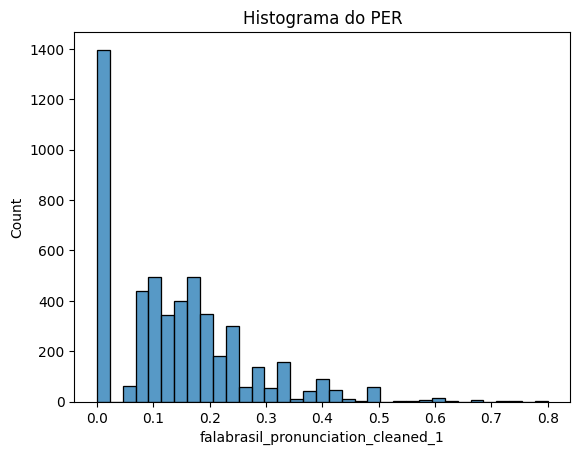

In [70]:
sns.histplot(standard_df_cer['falabrasil_pronunciation_cleaned_1'])
plt.title('Histograma do PER')
plt.show()